<a href="https://colab.research.google.com/github/jgaomcintosh/TeamUltron/blob/main/Baseline_Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [27]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
!sudo pip3 install keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA


In [28]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
r = requests.get(url)
filename = '101_ObjectCategories.tar.gz'
folderdername = filename.split('.')[0]
open(filename , 'wb').write(r.content)
# reference https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python
import tarfile
if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
elif filename.endswith("tar"):
    tar = tarfile.open(filename, "r:")
    tar.extractall()
    tar.close()

In [29]:
img_size =224
model = ResNet50(include_top=False, weights='imagenet',input_shape=(img_size, img_size, 3),pooling='max')

In [30]:
batch_size = 64
root_dir = '/content/lfw'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))
feature_list = model.predict(datagen, num_epochs)
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Found 13233 images belonging to 5749 classes.
Num images   =  13233
Shape of feature_list =  (13233, 2048)


In [31]:
# Get full path for all the images in our dataset
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [32]:
neighbors = NearestNeighbors(n_neighbors=8,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=8)

In [33]:
#Load Data from Google Drive 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

img_path = '/content/drive/MyDrive/George-W-Bush.jpeg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

Mounted at /content/drive


In [34]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

(1, 8)


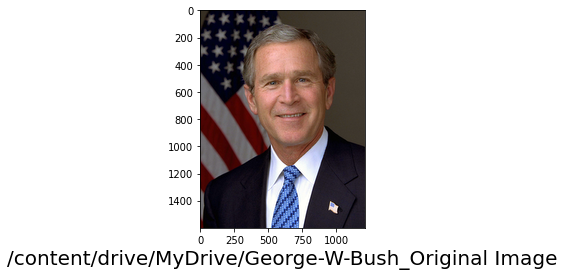

********* Predictions ***********


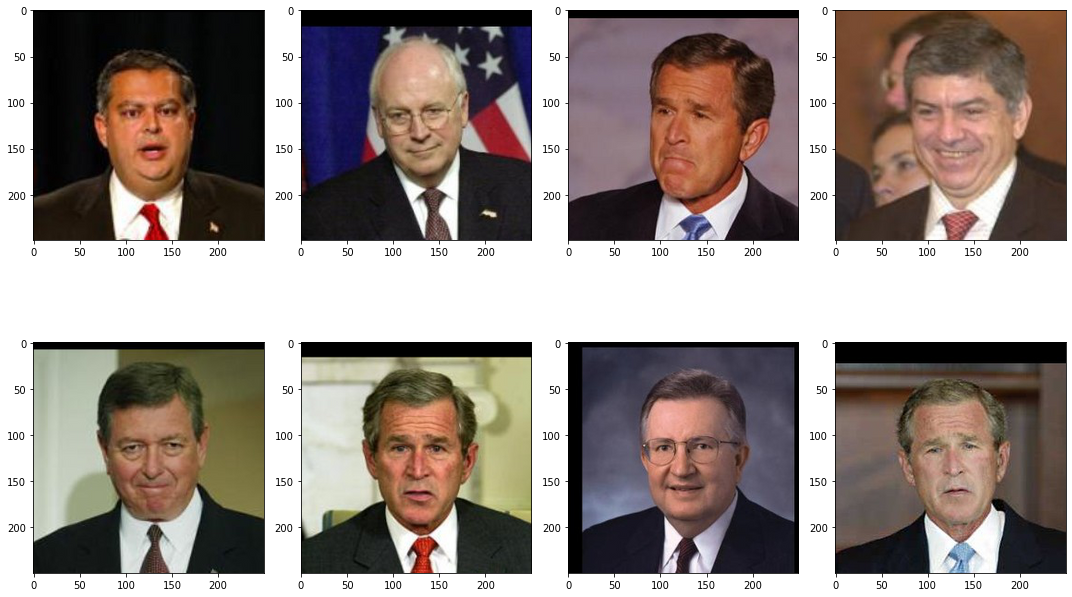

In [35]:
print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [39]:
pca = PCA(n_components=1700)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [40]:
neighbors_pca_features = NearestNeighbors(n_neighbors=8,
                             algorithm='ball_tree',                               metric='euclidean')
neighbors_pca_features.fit(compressed_features)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=8)

(1, 8)


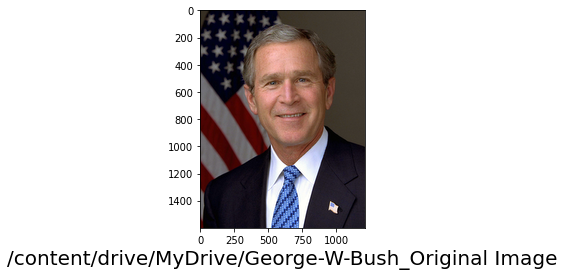

********* Predictions ***********


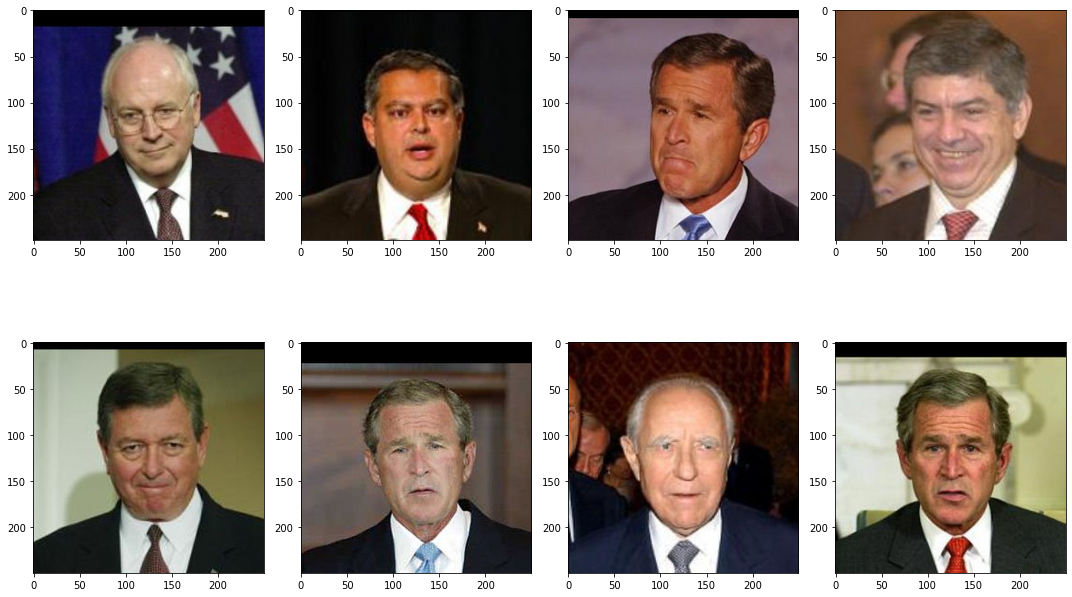

In [41]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])